## Import

In [1]:
# this is for google colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import os 

# tool_path = "/content/drive/Shared drives/Shared Task SentiMix/tools"

# import tools

# import tools.baseline as bt
# import tools.data as data_tools
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from gensim.models import Word2Vec, KeyedVectors
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding, Bidirectional, Dropout, Conv1D, GlobalMaxPool1D
from keras.utils import to_categorical
from keras.models import Model, Input
from keras.optimizers import Adam
from collections import defaultdict
import json

from keras.layers import *


Using TensorFlow backend.


In [3]:
def read_corpus(corpus_file):
    """read input document and return the textual articles
    and either the bias or hyperpartisan label"""

    with open(corpus_file) as json_file:
        data = json.load(json_file)

    data = pd.DataFrame(data)
    documents = data.text
    labels_bin = data.hyperp
    labels_mult = data.bias


    return documents, labels_bin, labels_mult

## Import Data

In [4]:
X, Y_bin, Y_mult = read_corpus('tokenized_with_NUM.json')

In [5]:
Xtrain, Xtest, Ytrain_bin, Ytest_bin, Ytrain_mult, Ytest_mult = train_test_split(X, 
                                                Y_bin, 
                                                Y_mult, 
                                                test_size = 0.2,
                                                stratify = Y_bin)

In [6]:
toki = Tokenizer()
toki.fit_on_texts(Xtrain)

In [7]:
Xtrain_seq = toki.texts_to_sequences(Xtrain)
Xtest_seq = toki.texts_to_sequences(Xtest)

In [8]:
print(Xtrain_seq[0])

[557, 4955, 8122, 488, 9735, 7, 4258, 1401, 135, 8, 2703, 2, 52, 18, 1968, 1188, 19, 1481, 1172, 10806, 7544, 8122, 3, 13, 8123, 36, 66, 11, 257, 265, 140, 2061, 8, 1481, 643, 6, 31, 463, 1928, 1252, 8, 1, 4258, 262, 4956, 5, 1, 135, 972, 1, 262, 50, 28, 2380, 857, 8, 309, 6, 723, 5, 444, 2703, 11, 730, 1, 23551, 72, 8, 1, 146, 17, 1, 657, 385, 2, 7545, 178, 2, 48, 236, 2, 523, 2, 6, 48, 2809, 4957, 3, 39, 3, 211, 31, 166, 4, 28, 8824, 12, 17499, 8, 2703, 2, 3, 8122, 131, 7, 323, 3745, 4594, 3, 15, 3, 13, 14415, 10807, 12, 2810, 7052, 6, 3264, 8, 1, 1928, 5, 6291, 8, 81, 4778, 3, 1, 262, 50, 28, 3337, 1, 1040, 5, 420, 707, 7053, 8, 2703, 2, 167, 59, 8, 23552, 24, 30, 9, 20, 8124, 2381, 50, 28, 71, 57, 828, 22, 23553, 6, 24, 30, 9, 20, 8, 175, 1727, 3, 23554, 6, 23555, 4958, 3, 38, 43, 184, 4, 192, 10808, 17, 62, 1550, 4, 1189, 7, 135, 10, 43, 691, 7, 1481, 4258, 4, 27, 1113, 6, 4007, 12322, 2, 3, 1172, 7544, 2598, 3, 23556, 643, 3, 29, 391, 7, 995, 3029, 12, 1, 205, 1076, 8, 46, 708, 1

In [9]:
word2index = toki.word_index
word2index['PAD'] = 0

In [10]:
index2word = toki.index_word
index2word[0] = 'PAD'
print(index2word[0])

PAD


In [11]:
#get max length of words

lens = [len(text) for text in Xtrain]

max_article_len = max(lens)
mean_article_len = np.mean(lens)
print(max_article_len, mean_article_len)

max_len = 1000

3157 602.4209006928406


In [12]:
#pre-pad the tweets with value 0
# that is prepadding (Louis so you understand as well)
Xtrain_pad = pad_sequences(Xtrain_seq, maxlen = max_len)
Xtest_pad = pad_sequences(Xtest_seq, maxlen = max_len)

### Labels

In [13]:
Ytrain_bin[:3]

237     False
1752     True
208     False
Name: hyperp, dtype: bool

In [14]:
Ytrain_bin = np.asarray([0. if l == False else 1. for l in Ytrain_bin])
Ytest_bin = np.asarray([0. if l == False else 1. for l in Ytest_bin])

In [15]:
# Ytrain_bin = to_categorical(Ytrain_bin)
# Ytest_bin = to_categorical(Ytest_bin)

In [16]:
Ytest_bin[:3]

array([0., 1., 1.])

In [17]:
mult_labels = set(Ytrain_mult)

In [18]:
label_dict = defaultdict()
for i, l in enumerate(mult_labels):
    label_dict[l] = i
    
print(label_dict)

defaultdict(None, {'right-center': 0, 'left': 1, 'least': 2, 'left-center': 3, 'right': 4})


In [19]:
Ytrain_mult = [label_dict[label] for label in Ytrain_mult]
Ytest_mult = [label_dict[label] for label in Ytest_mult] 

# this is now a list of numbers

In [20]:
no_cls = len(label_dict)

Ytrain_mult_cat = np.asarray([to_categorical(label, num_classes = no_cls) for label in Ytrain_mult])
Ytest_mult_cat = np.asarray([to_categorical(label, num_classes = no_cls) for label in Ytest_mult])

In [21]:
print('Shape of data tensor:', Xtrain_pad.shape)
print('Shape of binary label tensor:', Ytrain_bin.shape)
print('Shape of multilabel tensor:', Ytrain_mult_cat.shape)

Shape of data tensor: (1732, 1000)
Shape of binary label tensor: (1732,)
Shape of multilabel tensor: (1732, 5)


### Prepare the Embedding Layer

In [22]:
w2v_path = 'data/GoogleNews-vectors-negative300.bin'
embeddings = Word2Vec.load('model_all.bin')
embed_len = 100


#embed_w2v = KeyedVectors.load_word2vec_format(w2v_path, binary=True)

In [23]:
#w = filter(lambda x: x in model.vocab, list(model.wv.vocab))
#print model.most_similar(positive=w)

def load_embeddings(model, i2w, embed_len):
    
    index2embed = dict()
    w = filter(lambda x: x in word2index.keys(), list(embeddings.wv.vocab))

    for i, w in i2w.items():
        try:
            embed = model[w]
        except KeyError:
            embed = np.zeros(embed_len)
            #embed = embeddings.most_similar(positive=w)
        index2embed[i] = embed
    
    return index2embed

def load_w2v(model,i2w):
    index2emb = dict()
    
    for i, w in i2w.items():
        try:
            embed = model[w]
        except KeyError:
            embed = model['UNK']
            #embed = embeddings.most_similar(positive=w)
        index2embed[i] = embed
    
    return index2embed


In [24]:
#index2embed = loadw2v(embed_w2v, index2word)
index2embed = load_embeddings(embeddings, index2word, embed_len)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [25]:
#compute embedding matrix

embedding_matrix = np.zeros((len(word2index) + 1, embed_len))
for word, i in word2index.items():
    embedding_vector = index2embed[i]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [26]:
#load embedding matrix into embedding layer


embedding_layer = Embedding(len(word2index) + 1,
                            embed_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### Building the classifier - CNN

In [27]:
def cnn(binary, embedding = embedding_layer, lr = 0.001, hidden = 250):
    
    if binary:
        loss = 'binary_crossentropy'
        out = 1
        act_out = 'sigmoid'
    else:
        loss = 'categorical_crossentropy'
        out = 5
        act_out = 'softmax'
    
    
    filters = 250
    kernel_size = 3
    optim = Adam(lr=lr)
    
    sequence_input = Input(shape=(max_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    drop1 = Dropout(0.2)(embedded_sequences)

    conv1 = Conv1D(filters,
                  kernel_size,
                  padding = 'valid',
                  activation = 'relu',
                  strides = 1)(drop1)

    pool = GlobalMaxPool1D()(conv1)

    dense1 = Dense(hidden, activation='relu')(pool)
    drop2 = Dropout(0.2)(dense1)
    output = Dense(out, activation = act_out)(drop2)
    model = Model(inputs=sequence_input, outputs=output)
    model.compile(loss=loss, optimizer=optim, metrics=['accuracy'])

    model.summary()
    
    return model

In [28]:
model_bin = cnn(binary = True)
model_mult = cnn(binary = False)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         4179700   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 998, 250)          75250     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               62750     
_______________________________

In [30]:
epochs = 50
batch = 512
history_mult = model_mult.fit(Xtrain_pad, 
                              Ytrain_mult_cat, 
                              batch_size=batch, 
                              epochs=epochs, 
                              verbose=1)

Epoch 1/50
1732/1732 [==============================] - 6s 3ms/step - loss: 3.5009 - accuracy: 0.2673
Epoch 2/50
1732/1732 [==============================] - 6s 3ms/step - loss: 2.3006 - accuracy: 0.2766
Epoch 3/50
1732/1732 [==============================] - 6s 3ms/step - loss: 2.1938 - accuracy: 0.3118
Epoch 4/50
1732/1732 [==============================] - 6s 3ms/step - loss: 1.8328 - accuracy: 0.3522
Epoch 5/50
1732/1732 [==============================] - 6s 3ms/step - loss: 1.5198 - accuracy: 0.4105
Epoch 6/50
1732/1732 [==============================] - 5s 3ms/step - loss: 1.4310 - accuracy: 0.4319
Epoch 7/50
1732/1732 [==============================] - 6s 3ms/step - loss: 1.2051 - accuracy: 0.5167
Epoch 8/50
1732/1732 [==============================] - 6s 4ms/step - loss: 1.1733 - accuracy: 0.5254
Epoch 9/50
1732/1732 [==============================] - 6s 4ms/step - loss: 1.0515 - accuracy: 0.5912
Epoch 10/50
1732/1732 [==============================] - 6s 4ms/step - loss: 1.021

In [31]:
import matplotlib.pyplot as plt

def plot_history(history):

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    #plt.plot(history.history['loss'])
    #plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    #plt.legend(['Acc', 'Loss'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    #plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    #plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

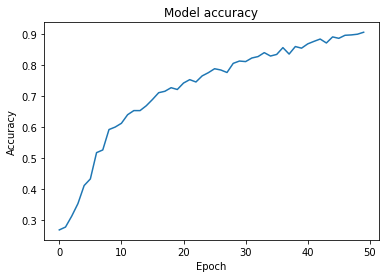

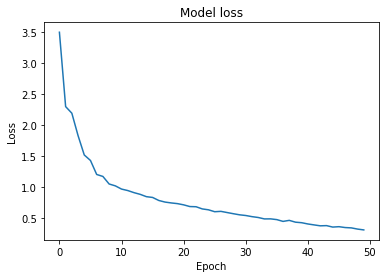

In [32]:
plot_history(history_mult)

In [33]:
predictions = model_mult.predict(Xtest_pad)

In [34]:
def report(true, pred):
    # binary classification returns a matrix with shape (X,1),
    # multiclass returns shape (X,5)
    if pred.shape[1] == 1:
        pred_converted = [0 if p < 0.5 else 1 for p in pred]
    else:
        pred_converted = np.argmax(pred, axis=1)
        
    print(classification_report(true, pred_converted))
    
    return 
        

In [35]:
report(Ytest_mult, predictions)

              precision    recall  f1-score   support

           0       0.76      0.78      0.77        83
           1       0.58      0.67      0.62        87
           2       0.64      0.61      0.62        76
           3       0.72      0.69      0.71       101
           4       0.91      0.84      0.87        86

    accuracy                           0.72       433
   macro avg       0.72      0.72      0.72       433
weighted avg       0.72      0.72      0.72       433

